<a href="https://colab.research.google.com/github/tom-schoener/ml-probability/blob/master/tfp-evaluation/notebooks/air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install --upgrade tf-nightly
!pip install --upgrade tfp-nightly

from datetime import datetime, timedelta

import collections
from scipy.interpolate import interp1d
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

Requirement already up-to-date: tf-nightly in /usr/local/lib/python3.6/dist-packages (1.14.1.dev20190424)
Requirement already up-to-date: tfp-nightly in /usr/local/lib/python3.6/dist-packages (0.7.0.dev20190424)


# Air Quality Test Data
Source: https://archive.ics.uci.edu/ml/datasets/Air+quality

hosted CSV: https://raw.githubusercontent.com/tom-schoener/ml-probability/master/data/air-quality/AirQualityUCI.csv

In [30]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/tom-schoener/ml-probability/master/data/air-quality/AirQualityUCI.csv", delimiter=";", decimal=",")
df_raw.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [31]:
# Cleanup
df = df_raw.copy()

# Remove empty rows and columns
# NMHC(GT) has < 20% values
df.dropna(thresh=2, inplace=True)
df.drop(df.columns[[4, 15, 16]], axis=1, inplace=True)

# -200 is missing data => NaN
df[df == -200] = np.nan

# NaN => 0
df.dropna(inplace=True)

# Date and DateTime
date_time_col = pd.to_datetime(df['Date'] + " " + df['Time'], format="%d/%m/%Y %H.%M.%S")
df.insert(loc=0, column='Date_Time', value=date_time_col)
df.drop(["Date", "Time"], axis=1, inplace=True)

# Date index 
df.set_index(pd.DatetimeIndex(df['Date_Time']), inplace=True)

# Sanitized data frame
print("shape: " + str(df.shape))
df.head()

shape: (6941, 13)


,Date_Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


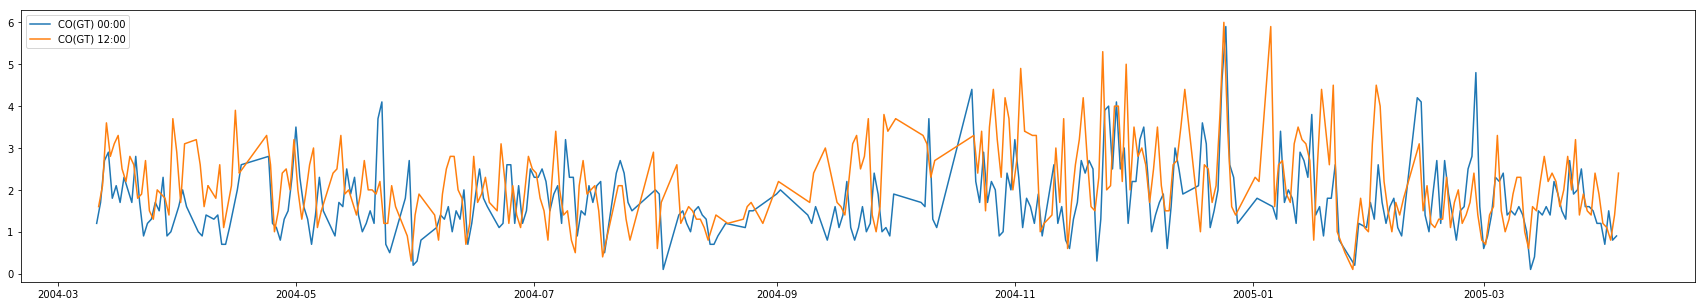

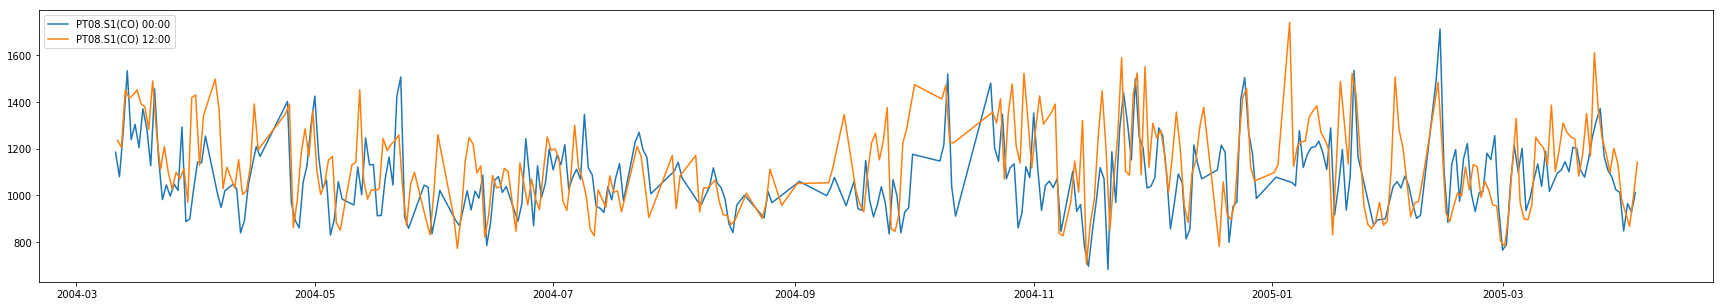

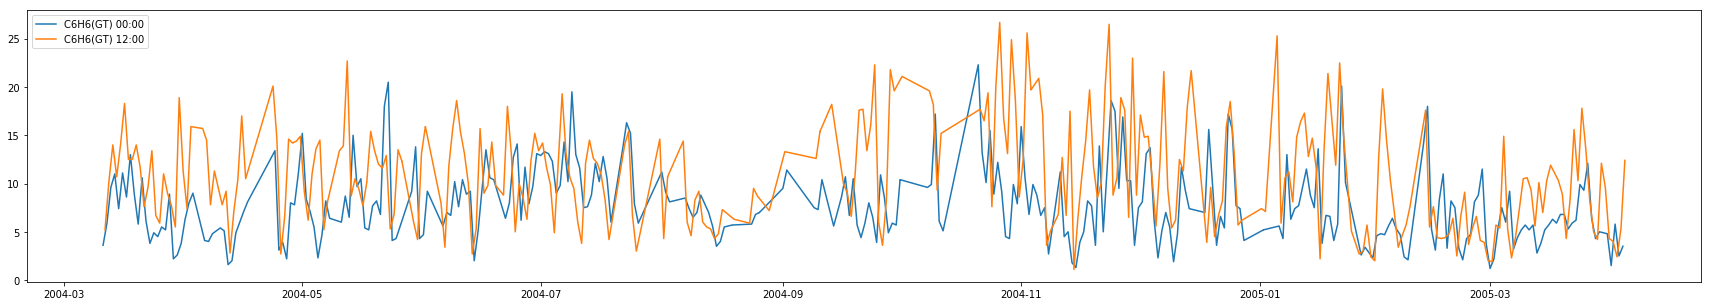

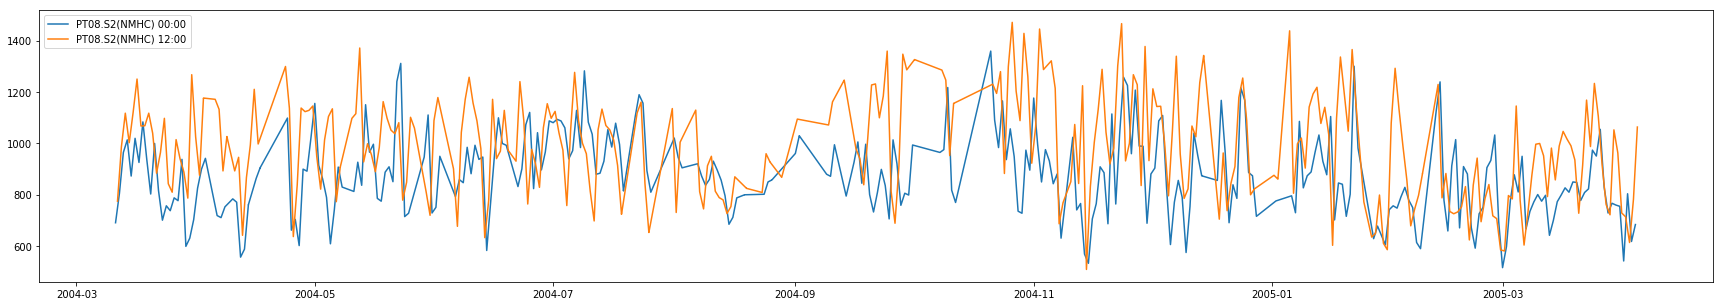

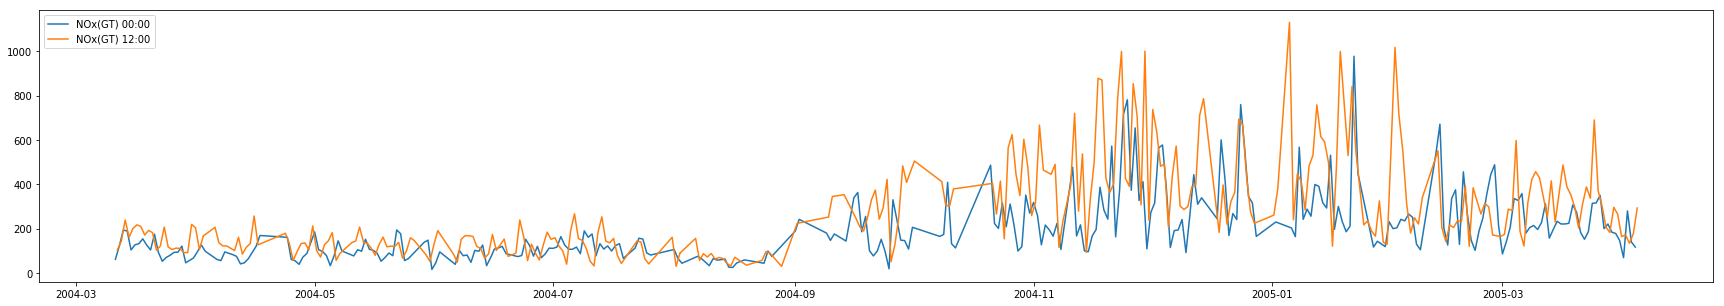

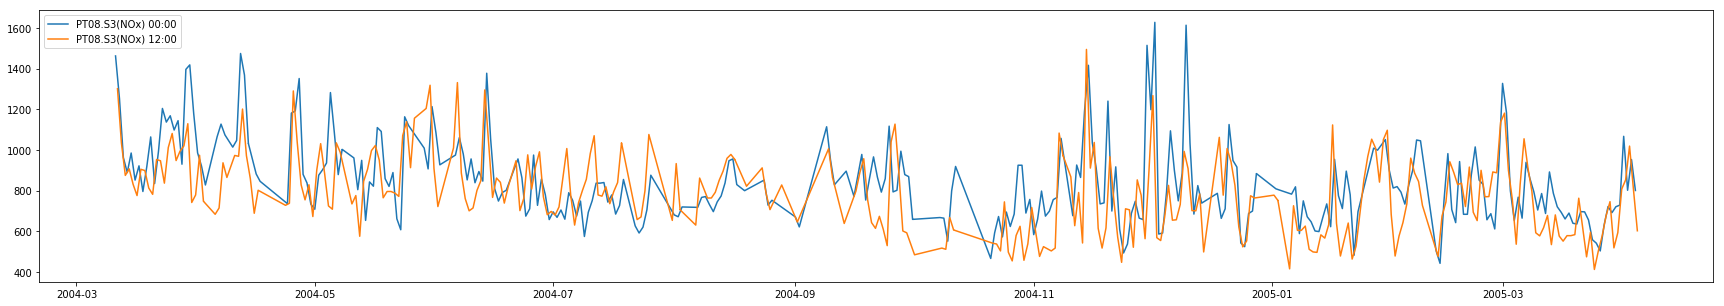

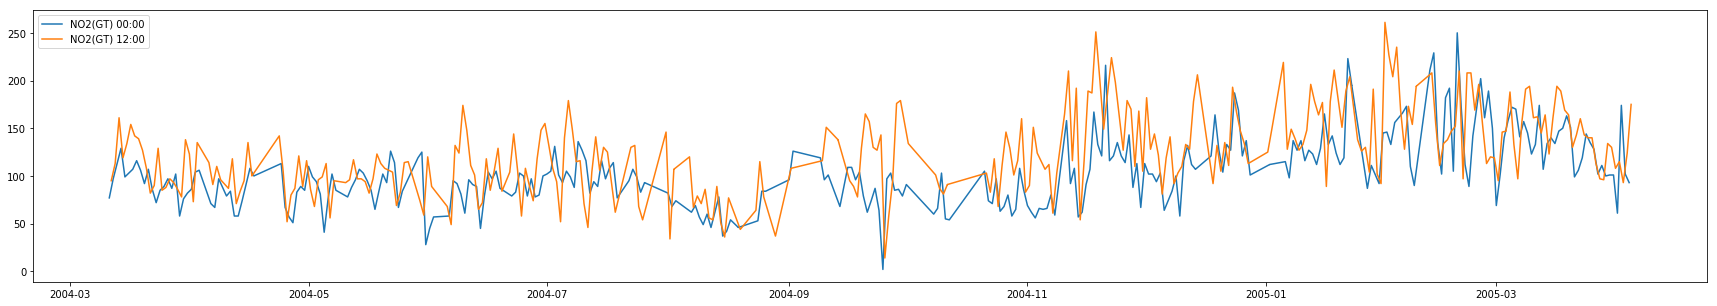

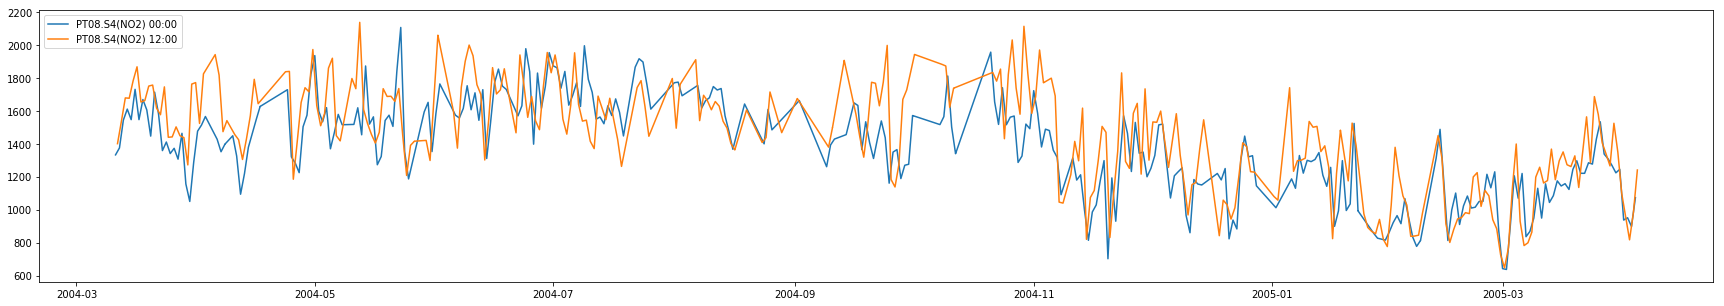

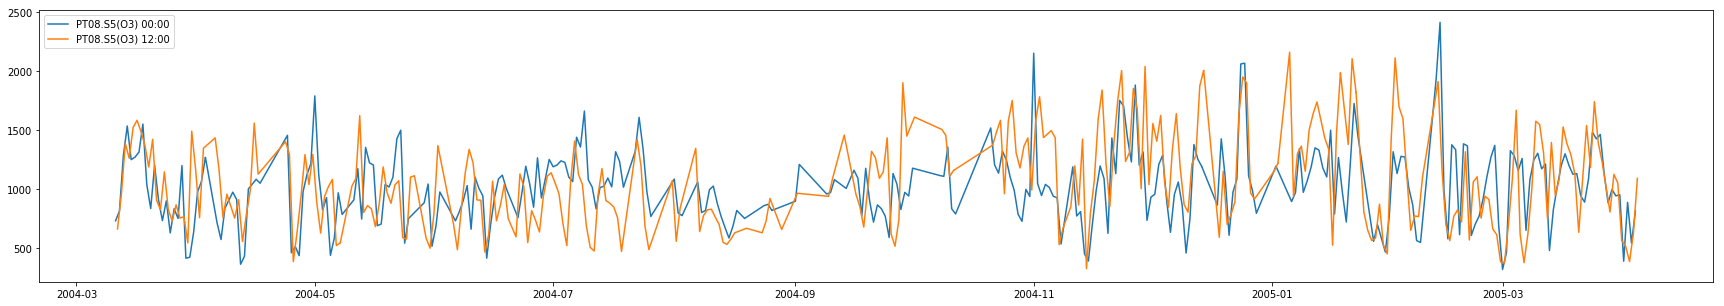

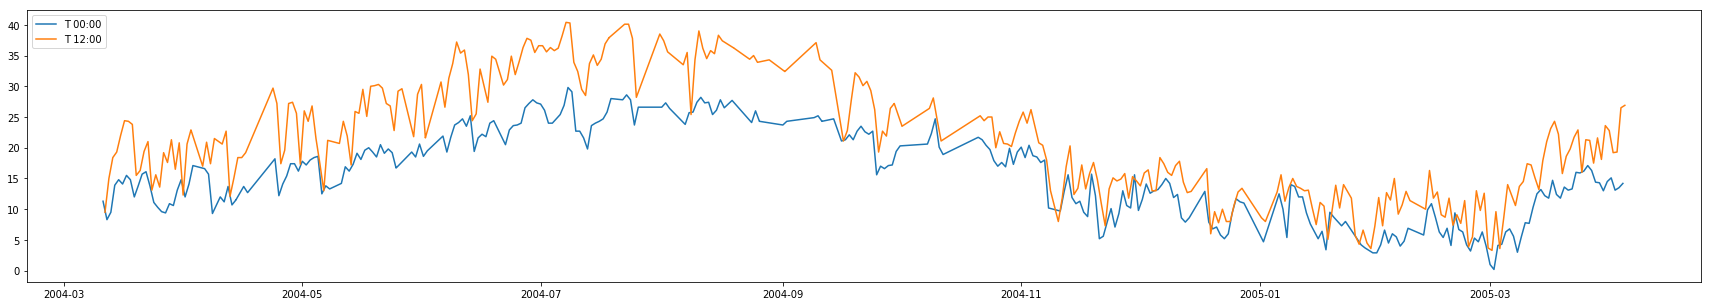

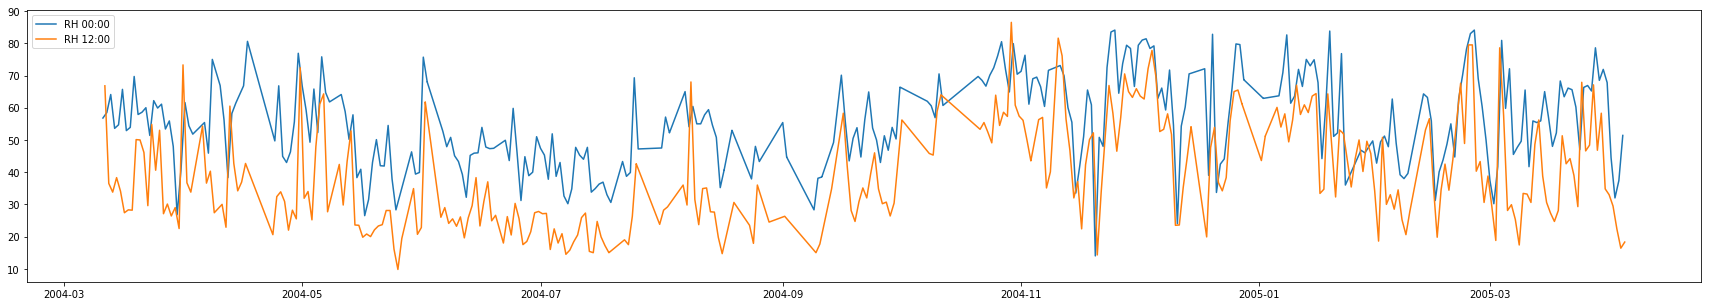

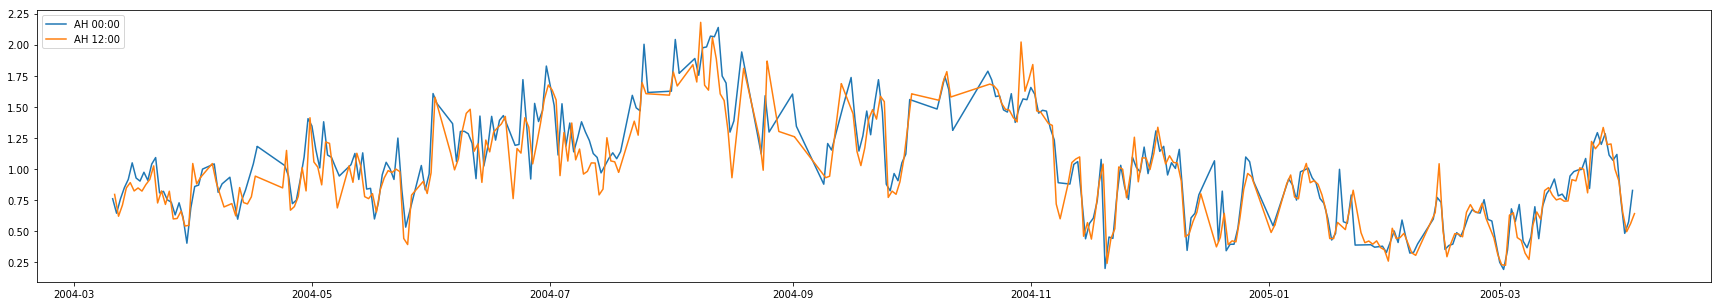

In [0]:
# Plots

def create_day_range(hour, freq='1D'):
  start = df['Date_Time'][0]
  end = df['Date_Time'][df.shape[0] - 1]
  
  start = start.replace(day=start.day + 1, hour=hour)
  unique_dates_col = pd.date_range(start=start, end=end, freq=freq)
  
  new_df = pd.DataFrame(df, index=unique_dates_col)
  new_df.fillna(inplace=True, method="pad")
  return new_df

def plot_at_hour(hour, column):
  hour_df = create_day_range(hour)
  hour_temp_col = hour_df[column]

  x = np.arange(hour_temp_col.shape[0])
  hour_temp_interp = interp1d(x=x , y=hour_temp_col, kind="cubic")
  plt.plot(hour_df['Date_Time'], hour_temp_interp(x), )


def plot_night_day(column):
  plt.figure(figsize=(30,5))
  plot_at_hour(0, column)
  plot_at_hour(12, column)
  plt.legend([column + ' 00:00', column + ' 12:00'], loc='upper left')
  plt.show()
  
for col in df.columns:
  if (col == "Date_Time"):
    continue
  plot_night_day(col)


# Neural Network without uncertainty

In [0]:
def model_no_uncertainty(feature, label, epochs=100):
  # feature
  x = np.array(df[feature])
  x = x[..., np.newaxis]

  # label
  y = np.array(df[label])
  
  # model
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
  ])

  # inference
  neg_log_lik = lambda y_, rv_y: -rv_y.log_prob(y_)
  model.compile(optimizer=tf.compat.v2.optimizers.Adam(learning_rate=0.01), loss=neg_log_lik)
  model.fit(x, y, epochs=epochs)
  
  return (x, y, model)


def plot_no_uncertainty(data, predictions, y_label):
  '''
  Plots the predicated data.
   
  data: [x, y] original data set
  predictions: [x, y'] predicted data set
  '''
  plt.plot(data[0], data[1], 'b.', label='observed');
  plt.plot(predictions[0], predictions[1].mean(), 'r', label='mean', linewidth=4);
  #plt.yticks(np.arange(0, 100, step=10));
  #plt.ylim((0, 100))

  ax=plt.gca();
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')
  ax.spines['left'].set_position(('data', 0))
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.xlabel('temperature')
  plt.ylabel(y_label)
  plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

**Features**: Temperatur, **Lables**: RH

In [0]:
#@title Label: RH: No uncertainty.

rh_x, rh_y, rh_model = model_no_uncertainty('T', 'RH')

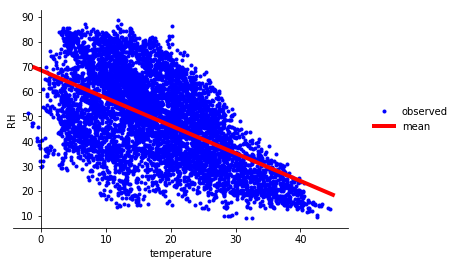

In [0]:
x_test = np.linspace(-1, 45, 50)
x_test = x_test[..., np.newaxis]
rh_predictions = rh_model(x_test)

plot_no_uncertainty((rh_x, rh_y), (x_test, rh_predictions), 'RH')

**Features**: Temperatur, **Lables**: NO2

In [0]:
#@title Label: NO2: No uncertainty.

no2_x, no2_y, no2_model = model_no_uncertainty('T', 'NO2(GT)', 250)

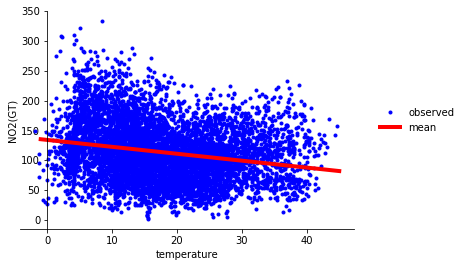

In [0]:
no2_x_test = np.linspace(-1, 45, 50)
no2_x_test = no2_x_test[..., np.newaxis]
no2_predictions = no2_model(x_test)

plot_no_uncertainty((no2_x, no2_y), (no2_x_test, no2_predictions), 'NO2(GT)')

# Neural Network with uncertainty

In [0]:
def model_with_uncertainty(feature, label, epochs=5000):
  # feature
  x = np.array(df[feature])
  x = x[..., np.newaxis]

  # label
  y = np.array(df[label])
  
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(2),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(
        loc=t[..., :1],
        scale=1e-3 + tf.math.softplus(5e-3 * t[...,1:])))
  ])

  # inference
  negloglik = lambda y_, rv_y: -rv_y.log_prob(y_)
  model.compile(optimizer=tf.compat.v2.optimizers.Adam(learning_rate=0.01), loss=negloglik)
  model.fit(x, y, epochs=epochs);

  return (x, y, model)


def plot_with_uncertainty(data, predictions, y_label):
  '''
  Plots the predicated data.
   
  data: [x, y] original data set
  predictions: [x, y'] predicted data set
  '''
  plt.plot(data[0], data[1], 'b.', label='observed');

  m = predictions[1].mean()
  s = predictions[1].stddev()


  plt.plot(predictions[0], m, 'r', linewidth=4, label='mean')
  plt.plot(predictions[0], m - s * 2, predictions[0], m + s * 2, label=r'mean +/- stddev', linewidth=3, color='g')

  ax=plt.gca();
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')
  ax.spines['left'].set_position(('data', 0))
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

**Features**: Temperatur, **Lables**: RH

In [0]:
# model
rh_x2, rh_y2, rh_model2 = model_with_uncertainty('T', 'RH')


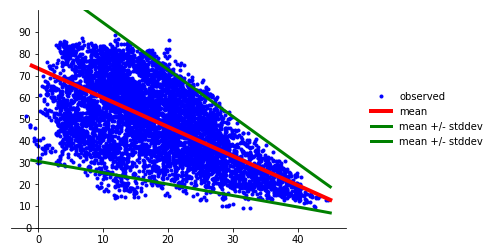

In [0]:
#@title Label RH: Aleatoric Uncertainty
rh_x_test2 = np.linspace(-1, 45, 50)
rh_x_test2 = rh_x_test2[..., np.newaxis]
rh_predictions2 = rh_model2(rh_x_test2)

assert isinstance(rh_predictions2, tfd.Distribution)

plot_with_uncertainty((rh_x2, rh_y2), (rh_x_test2, rh_predictions2), 'RH')

**Features**: Temperatur, **Lables**: NO2

In [33]:
# model
no2_x2, no2_y2, no2_model2 = model_with_uncertainty('T', 'NO2(GT)', 7500)

Epoch 1/7500
6941/6941 [==============================] - 0s 52us/sample - loss: 9090.9813
Epoch 2/7500
6941/6941 [==============================] - 0s 33us/sample - loss: 5655.6849
Epoch 3/7500
6941/6941 [==============================] - 0s 32us/sample - loss: 4471.9704
Epoch 4/7500
6941/6941 [==============================] - 0s 33us/sample - loss: 3873.2812
Epoch 5/7500
6941/6941 [==============================] - 0s 33us/sample - loss: 3454.7954
Epoch 6/7500
6941/6941 [==============================] - 0s 33us/sample - loss: 3118.4448
Epoch 7/7500
6941/6941 [==============================] - 0s 33us/sample - loss: 2836.0349
Epoch 8/7500
6941/6941 [==============================] - 0s 33us/sample - loss: 2594.1559
Epoch 9/7500
6941/6941 [==============================] - 0s 33us/sample - loss: 2384.3827
Epoch 10/7500
6941/6941 [==============================] - 0s 35us/sample - loss: 2200.6620
Epoch 11/7500
6941/6941 [==============================] - 0s 32us/sample - loss: 2038.19

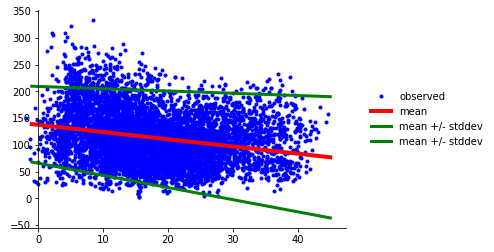

In [34]:
#@title Label NO2: Aleatoric Uncertainty
no2_x_test2 = np.linspace(-1, 45, 50)
no2_x_test2 = no2_x_test2[..., np.newaxis]
no2_predictions2 = no2_model2(no2_x_test2)

assert isinstance(no2_predictions2, tfd.Distribution)

plot_with_uncertainty((no2_x2, no2_y2), (no2_x_test2, no2_predictions2), 'NO2(GT)')